In [1]:
Atom = false
#Atom = true

false

In [2]:
using Gridap
using Test
using GridapODEs
if  !Atom 
    using GridapMakie, GLMakie
end
using FileIO
using GridapGmsh
using gmsh
using Gridap.CellData
using Gridap.Visualization
using Gridap.Arrays

In [3]:
L = 80.
model = GmshDiscreteModel("modelos/1D_sim_80.msh")

Info    : Reading 'modelos/1D_sim_80.msh'...
Info    : 5 entities
Info    : 5969 nodes
Info    : 5970 elements
Info    : Done reading 'modelos/1D_sim_80.msh'


UnstructuredDiscreteModel()

In [4]:
Ω = Triangulation(model)
degree = 3
dΩ = Measure(Ω,degree)

Measure()

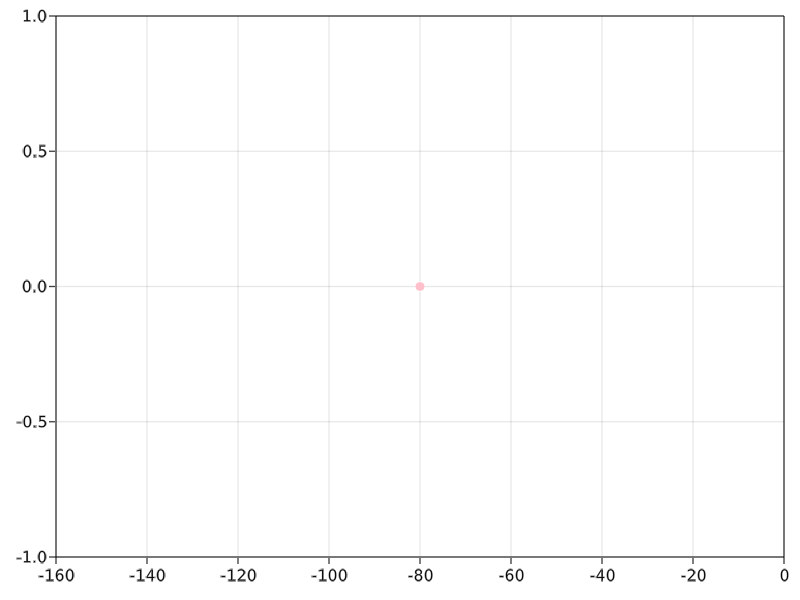

In [5]:
neumanntags_L= ["extI"]
Γ_L = BoundaryTriangulation(model,tags=neumanntags_L)
dΓ_L = Measure(Γ_L,degree)
if Atom == false 
    fig = plot(Γ_L, linewidth=8
    )
end

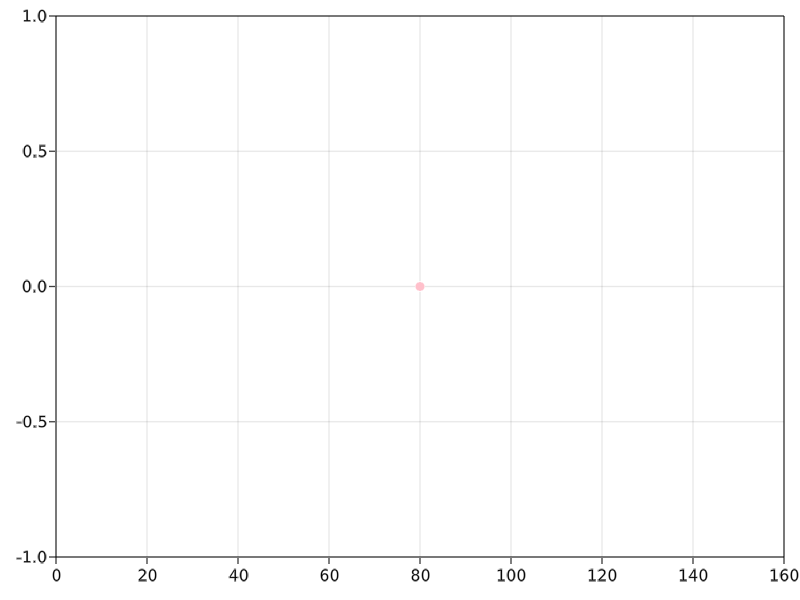

In [6]:
neumanntags_R= ["ext"]
Γ_R = BoundaryTriangulation(model,tags=neumanntags_R)
dΓ_R = Measure(Γ_R,degree)
if Atom == false 
    fig = plot(Γ_R, linewidth=8
    )
end

In [7]:
order = 2
reffe = ReferenceFE(lagrangian,Float64,order)
V = TestFESpace(model,reffe,conformity=:H1)
U = TrialFESpace(V)

UnconstrainedFESpace()

In [8]:
a0=1.
R=20
s(x) = sqrt((x[1]/ R)^2 ) 
q(x)=1. - s(x) ^4 * (1. - 5. *(s(x) -1.) + 15. * (s(x)-1.)^2 - 35. *(s(x) -1.)^3 +70. * (s(x)- 1.)^4)

function α(x)
    if abs(s(x))   < 1.0
        return q(x)*a0
        end
    if abs(s(x))  >= 1.0
       return  0.
    end
end

t(x) = 8*π*α(x)
#Cond de Newman borde centro
c(x)=0.

c (generic function with 1 method)

In [9]:
ρ(x)=abs(x[1])
ρvec(x) = VectorValue(1.)
sig(x)= sign(x[1])
d(x) = VectorValue(2. )
invrho3(x)=3. / x[1]

invrho3 (generic function with 1 method)

In [10]:
a(u,v) = ∫( - ∇(v) ⋅ ∇(u)*ρ +(d ⋅ ∇(u))*sig*v ) *dΩ -∫( v *( u  ) )*dΓ_R  -∫( v *( u  ) )*dΓ_L 
b(v) = ∫(-v * t* ρ) *dΩ 

b (generic function with 1 method)

In [11]:
op = AffineFEOperator(a,b,U,V)

AffineFEOperator()

In [12]:
ls = LUSolver()
solver = LinearFESolver(ls)

LinearFESolver()

In [13]:
uh = solve(solver,op)

SingleFieldFEFunction():
 num_cells: 5968
 DomainStyle: ReferenceDomain()
 Triangulation: BodyFittedTriangulation()
 Triangulation id: 5527200084102585427

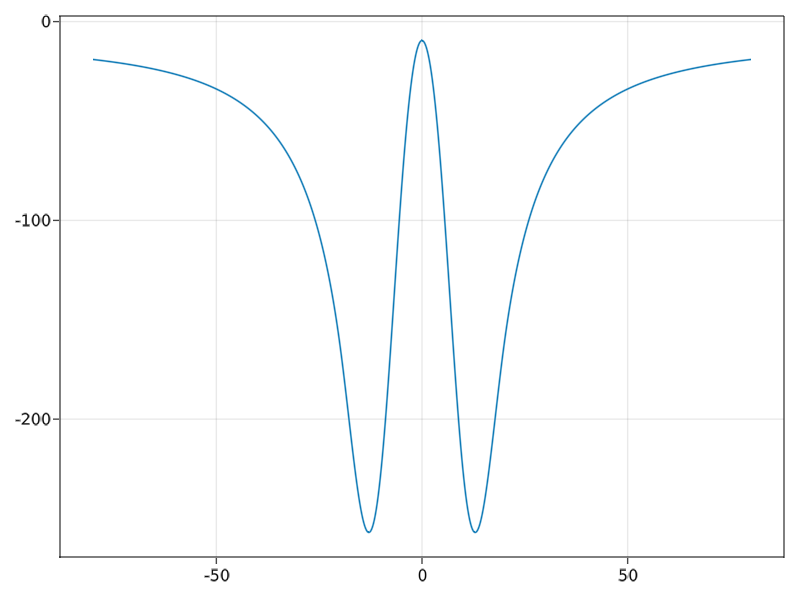

In [14]:
x = range(-L, L, length=1000)
lines(x, evaluate(uh, Gridap.Point.(x)), label= "u")

In [15]:
f1=∇(uh) ⋅ ρvec

OperationCellField():
 num_cells: 5968
 DomainStyle: ReferenceDomain()
 Triangulation: BodyFittedTriangulation()
 Triangulation id: 5527200084102585427

In [16]:
invrho3(x)=3. /x[1]

invrho3 (generic function with 1 method)

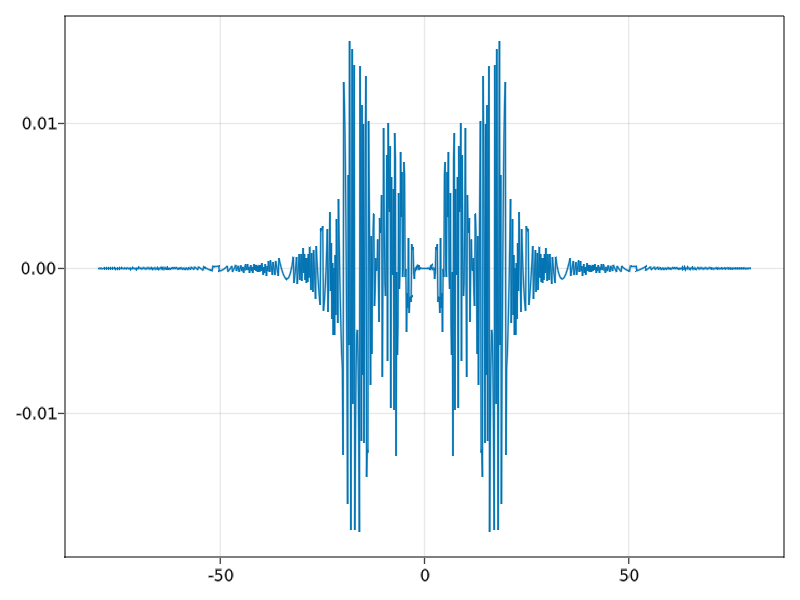

In [17]:
x = range(-L, L, length=1000) #residual
lines(x, evaluate( Δ(uh)+invrho3*f1+t, Gridap.Point.(x)), label= "u")

In [18]:
function t1(x)
  return 2. * π*α(x)
end

function t2(x)
  return 6. * π*α(x)
end

t2 (generic function with 1 method)

In [19]:
F=f1*f1

OperationCellField():
 num_cells: 5968
 DomainStyle: ReferenceDomain()
 Triangulation: BodyFittedTriangulation()
 Triangulation id: 5527200084102585427

In [20]:
res(w,q)=  ∫(  - (∇(q) ⋅ ∇(w))*ρ  + t1*( (q*ρ * ρ)/(w*w*w)) +  (0.25 * F *ρ *  ρ* ρ) * q*(1/(w*w*w*w*w*w*w)) ) *dΩ +∫(-q * (w- 1.)  ) *dΓ_L +∫( -q * (w- 1.)  ) *dΓ_R 

res (generic function with 1 method)

In [21]:
jac(w,dw,q)= ∫(  - ( ∇(q) ⋅ ∇(dw))*ρ   - ((dw* q*ρ * ρ)/(w*w*w*w))*t2 -(1.75 * F *ρ  * ρ* ρ) * dw *q*(1/(w*w*w*w*w*w*w*w)) ) *dΩ+∫( -q * (dw)  ) *dΓ_L+∫( -q * (dw)  ) *dΓ_R

jac (generic function with 1 method)

In [22]:
oppsi = FEOperator(res,jac,U,V)

FEOperatorFromWeakForm()

In [23]:
using LineSearches: BackTracking
nls = NLSolver(
  show_trace=true, method=:trust_region, linesearch=BackTracking(),ftol=1E-20, xtol= 1E-20,iterations=100)
solver = FESolver(nls)

NonlinearFESolver()

In [24]:
seed(x)=1. 
w0=interpolate_everywhere(seed,U)

SingleFieldFEFunction():
 num_cells: 5968
 DomainStyle: ReferenceDomain()
 Triangulation: BodyFittedTriangulation()
 Triangulation id: 5527200084102585427

In [25]:
w, = solve!(w0,solver,oppsi)

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.032226e+04              NaN
     1     4.053355e+03     1.811554e+01
     2     1.591631e+03     2.060845e+01
     3     6.249573e+02     2.341141e+01
     4     2.453714e+02     2.664265e+01
     5     9.632500e+01     3.040384e+01
     6     3.780544e+01     3.477116e+01
     7     1.483201e+01     3.981483e+01
     8     5.816209e+00     4.560110e+01
     9     2.279444e+00     5.217843e+01
    10     8.909783e-01     5.952295e+01
    11     3.451148e-01     6.725705e+01
    12     1.283871e-01     7.175424e+01
    13     4.228392e-02     6.084475e+01
    14     1.485268e-02     4.500375e+01
    15     8.642515e-03     3.588094e+01
    16     3.134744e-03     2.716453e+01
    17     4.270842e-04     1.339168e+01
    18     8.873478e-06     2.213958e+00
    19     4.125463e-09     4.926839e-02
    20     8.375300e-12     2.354190e-05
    21     7.978646e-12     0.000000e+00
    22     7.97864

(SingleFieldFEFunction(), NLSolversCache())

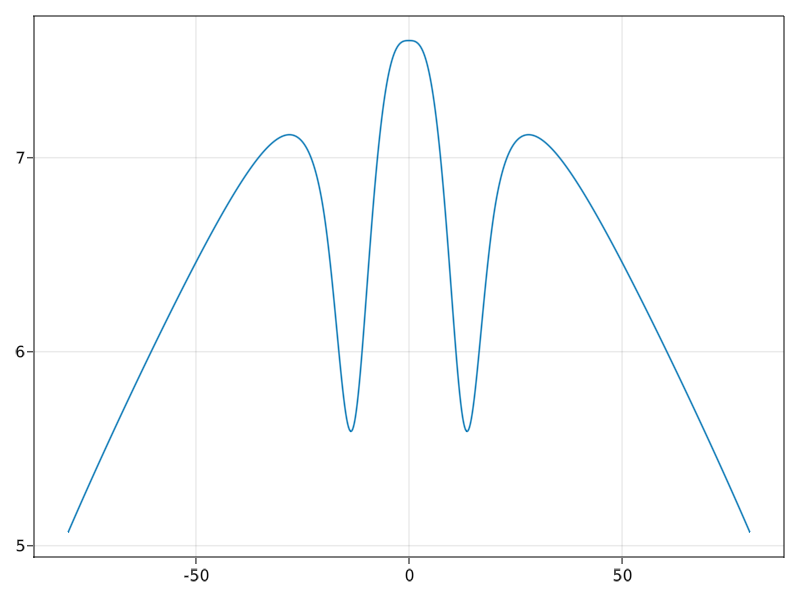

In [26]:
x = range(-L, L, length=1000)
lines(x, evaluate(w,Gridap.Point.(x)), label= "u")

In [27]:
invrho(x)=1. /x[1]
partialψ=ρvec ⋅ ∇(w)

OperationCellField():
 num_cells: 5968
 DomainStyle: ReferenceDomain()
 Triangulation: BodyFittedTriangulation()
 Triangulation id: 5527200084102585427

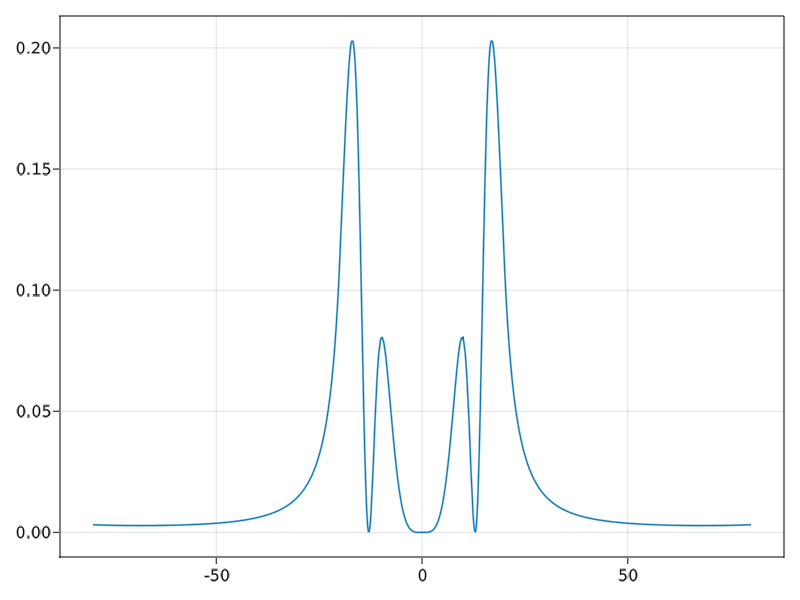

In [28]:
x = range(-L, L, length=1000)
lines(x, evaluate(Δ(w)+invrho*partialψ + t1 *(ρ/ (w*w*w))+F *ρ*ρ/(w*w*w*w*w*w*w),Gridap.Point.(x)), label= "u")